# Dataset Analysis and Pipeline Validation
## Image-Based Product Category Classification

This notebook covers the initial analysis of the raw dataset and validates the effectiveness of our automated data preparation pipeline.

The goals of this notebook are to:
- Inspect the raw dataset and its original category distribution.
- **Validate the new category structure** created by our NLP-based merging script.
- **Analyze the balance of the final, merged dataset**.
- Verify data quality, such as the validity of image URLs.

In [13]:
# Import tools needed for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
from concurrent.futures import ThreadPoolExecutor

plt.style.use("default")

## 1. Loading the Dataset

The dataset is provided as two CSV files, the first one contains product title, image URLs and category id.
The categories.csv, has the categories names.
Due to its size, the dataset is hosted externally and downloaded using a dedicated script.

In [14]:
products_df = pd.read_csv("../data/raw/products.csv")
categories_df = pd.read_csv("../data/raw/categories.csv")
products_df.head()

,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth
0,B014TMV5YE,"Sion Softside Expandable Roller Luggage, Black...",https://m.media-amazon.com/images/I/815dLQKYIY...,https://www.amazon.com/dp/B014TMV5YE,4.5,0,139.99,0.00,104,False,2000
1,B07GDLCQXV,Luggage Sets Expandable PC+ABS Durable Suitcas...,https://m.media-amazon.com/images/I/81bQlm7vf6...,https://www.amazon.com/dp/B07GDLCQXV,4.5,0,169.99,209.99,104,False,1000
2,B07XSCCZYG,Platinum Elite Softside Expandable Checked Lug...,https://m.media-amazon.com/images/I/71EA35zvJB...,https://www.amazon.com/dp/B07XSCCZYG,4.6,0,365.49,429.99,104,False,300
3,B08MVFKGJM,Freeform Hardside Expandable with Double Spinn...,https://m.media-amazon.com/images/I/91k6NYLQyI...,https://www.amazon.com/dp/B08MVFKGJM,4.6,0,291.59,354.37,104,False,400
4,B01DJLKZBA,Winfield 2 Hardside Expandable Luggage with Sp...,https://m.media-amazon.com/images/I/61NJoaZcP9...,https://www.amazon.com/dp/B01DJLKZBA,4.5,0,174.99,309.99,104,False,400


In [15]:
print(f"Number of samples: {len(products_df)}")
print(f"Number of columns: {len(products_df.columns)}")
products_df.columns

Number of samples: 1426337
Number of columns: 11


Index(['asin', 'title', 'imgUrl', 'productURL', 'stars', 'reviews', 'price',
       'listPrice', 'category_id', 'isBestSeller', 'boughtInLastMonth'],
      dtype='object')

- The dataset contains product title, image URLs and their corresponding category id.
- The category labels are stored in a seperate csv file.
- The following analysis focuses on cleaning and refining these fields.

## 2. Raw Category Inspection

We first examine the distribution of all available categories to understand their frequency and suitability for image-based classification.

In [16]:
raw_category_counts = products_df["category_id"].value_counts()
print(categories_df[["id","category_name"]].head())

print("\nMin frequency of a category: " + str(raw_category_counts.min()))
print("Max frequency of a category: " + str(raw_category_counts.max()))
print("Mean frequency of a category: " + str(int(raw_category_counts.mean())))

   id                     category_name
0   1          Beading & Jewelry Making
1   2                 Fabric Decorating
2   3       Knitting & Crochet Supplies
3   4              Printmaking Supplies
4   5  Scrapbooking & Stamping Supplies

Min frequency of a category: 22
Max frequency of a category: 28619
Mean frequency of a category: 5751


## 3. Automated Category Merging

The original dataset contains 248 categories, many of which are either too specific, too broad, or semantically very similar. A manual approach to filtering or merging is not scalable or reproducible.

Also there are some categories that have a few products in them, and can unbalance the dataset.

To solve this, we implemented an automated pipeline that uses **NLP (Sentence-Transformers) and Clustering (K-Means)** to group the 248 original categories into a more manageable and balanced set of around 50 new categories. 

The following steps analyze the result of that pipeline.

First, we load the final processed dataset and the mapping file generated by our scripts.

In [23]:
# Load the results of the new data preparation pipeline
products_cleaned_df = pd.read_csv("../data/processed/products_cleaned.csv")
mapping_df = pd.read_csv("../data/processed/category_mapping.csv")

print(f"Loaded {len(products_cleaned_df)} cleaned products.")
print(f"Loaded mapping for {len(mapping_df)} original categories into {mapping_df['merged_category_id'].nunique()} new categories.")

Loaded 1421985 cleaned products.
Loaded mapping for 235 original categories into 47 new categories.


For securing the dataset, categories with fewer than 100 samples were removed to ensure
a more balanced and learnable dataset.

After modifying, the final category set is obtained.
These categories are visually distinguishable and suitable for classification.


## 4. Dataset Balance Analysis

We analyze the number of samples per category to assess dataset balance.

In [24]:
# Getting ready for visualization
category_counts = products_cleaned_df["merged_category_id"].value_counts()
category_counts_df = (
    category_counts
    .reset_index()
)
category_counts_df.columns = ["merged_category_id", "count"]
category_counts_df = category_counts_df.merge(
    mapping_df,
    on="merged_category_id",
    how="left"
)

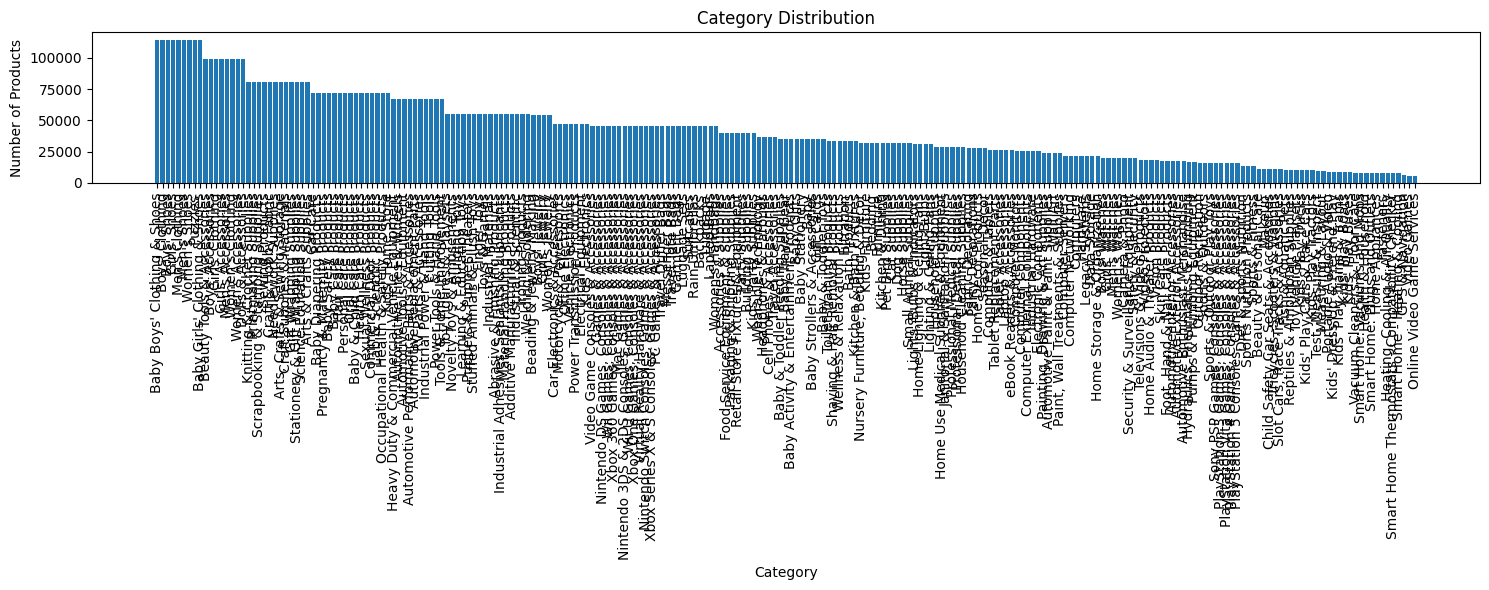

In [26]:
plt.figure(figsize=(15, 6))

plt.bar(
    category_counts_df["category_name"],
    category_counts_df["count"]
)

plt.xticks(rotation=90)
plt.xlabel("Category")
plt.ylabel("Number of Products")
plt.title("Category Distribution")

plt.tight_layout()
plt.show()

The graph shows some amount imbalance across categories.
This imbalance will be addressed in later phases using data augmentation and training strategies.

## 5. Image URL Quality Check

To assess data quality, we verify whether image URLs are reachable.
Due to dataset size, this check is performed on a random subset.


In [27]:
def is_url_valid(url):
    try:
        r = requests.get(
            url,
            timeout=5,
            stream=True,
            allow_redirects=True,
            headers={"User-Agent": "Mozilla/5.0"}
        )
        return r.status_code == 200
    except requests.RequestException:
        return False
    
def check_urls_parallel(urls, max_workers=40):
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for res in tqdm(executor.map(is_url_valid, urls), total=len(urls)):
            results.append(res)
    return results

sample_df = products_cleaned_df.sample(200, random_state=42).copy()

sample_df["valid"] = check_urls_parallel(
    sample_df["imgUrl"].tolist(),
    max_workers=20
)

sample_df["valid"].value_counts()

100%|██████████| 200/200 [00:20<00:00,  9.75it/s]


valid
True    200
Name: count, dtype: int64

The sample-based validation indicates that most image URLs are reachable.
Invalid URLs are removed automatically during the image download and training stage, where missing images will be skipped.

## Summary

In this notebook, we performed a full cycle of data analysis and pipeline validation:
- We began by inspecting the **raw dataset** and its original, imbalanced category structure.
- We then loaded the results of our **automated NLP-based category merging pipeline**.
- We **visualized the final dataset's balance**, confirming that the new 50 categories are much more evenly distributed.
- We reviewed the mapping to understand how original categories were grouped.
- We verified the quality of image URLs in the dataset.

The resulting dataset, `products_cleaned.csv`, is now validated and ready to serve as the foundation for model training.